In [1]:
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [4]:

# -----------------------------
# 1. Prepare Corpus & Vocabulary
# -----------------------------
sentences = [
    "NLP is fun and exciting",
    "We are learning natural language processing",
    "Machine learning powers modern NLP applications",
    "Natural language processing is a fascinating field",
    "Deep learning improves NLP performance",
    "We enjoy exploring text mining techniques",
    "AI is transforming language understanding"
]
tokens = [w.lower() for s in sentences for w in s.split()]
vocab_counter = Counter(tokens)
vocab = list(vocab_counter.keys())
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}
print(word2idx)
print(idx2word)



{'nlp': 0, 'is': 1, 'fun': 2, 'and': 3, 'exciting': 4, 'we': 5, 'are': 6, 'learning': 7, 'natural': 8, 'language': 9, 'processing': 10, 'machine': 11, 'powers': 12, 'modern': 13, 'applications': 14, 'a': 15, 'fascinating': 16, 'field': 17, 'deep': 18, 'improves': 19, 'performance': 20, 'enjoy': 21, 'exploring': 22, 'text': 23, 'mining': 24, 'techniques': 25, 'ai': 26, 'transforming': 27, 'understanding': 28}
{0: 'nlp', 1: 'is', 2: 'fun', 3: 'and', 4: 'exciting', 5: 'we', 6: 'are', 7: 'learning', 8: 'natural', 9: 'language', 10: 'processing', 11: 'machine', 12: 'powers', 13: 'modern', 14: 'applications', 15: 'a', 16: 'fascinating', 17: 'field', 18: 'deep', 19: 'improves', 20: 'performance', 21: 'enjoy', 22: 'exploring', 23: 'text', 24: 'mining', 25: 'techniques', 26: 'ai', 27: 'transforming', 28: 'understanding'}


In [5]:

# -----------------------------
# 2. Build training pairs
# -----------------------------
window = 2

def build_skipgram_pairs():
    pairs = []
    for s in sentences:
        words = s.lower().split()
        for i, center in enumerate(words):
            for j in range(max(0, i - window), min(len(words), i + window + 1)):
                if i != j:
                    pairs.append((word2idx[center], word2idx[words[j]]))
    return np.array(pairs)

def build_cbow_pairs():
    pairs = []
    for s in sentences:
        words = s.lower().split()
        for i, target in enumerate(words):
            context_indices = [word2idx[words[j]]
                               for j in range(max(0, i - window), min(len(words), i + window + 1))
                               if j != i]
            pairs.append((context_indices, word2idx[target]))
    return pairs

sg_pairs = build_skipgram_pairs()
cbow_pairs = build_cbow_pairs()
print(sg_pairs)
print(cbow_pairs)


[[ 0  1]
 [ 0  2]
 [ 1  0]
 [ 1  2]
 [ 1  3]
 [ 2  0]
 [ 2  1]
 [ 2  3]
 [ 2  4]
 [ 3  1]
 [ 3  2]
 [ 3  4]
 [ 4  2]
 [ 4  3]
 [ 5  6]
 [ 5  7]
 [ 6  5]
 [ 6  7]
 [ 6  8]
 [ 7  5]
 [ 7  6]
 [ 7  8]
 [ 7  9]
 [ 8  6]
 [ 8  7]
 [ 8  9]
 [ 8 10]
 [ 9  7]
 [ 9  8]
 [ 9 10]
 [10  8]
 [10  9]
 [11  7]
 [11 12]
 [ 7 11]
 [ 7 12]
 [ 7 13]
 [12 11]
 [12  7]
 [12 13]
 [12  0]
 [13  7]
 [13 12]
 [13  0]
 [13 14]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [14 13]
 [14  0]
 [ 8  9]
 [ 8 10]
 [ 9  8]
 [ 9 10]
 [ 9  1]
 [10  8]
 [10  9]
 [10  1]
 [10 15]
 [ 1  9]
 [ 1 10]
 [ 1 15]
 [ 1 16]
 [15 10]
 [15  1]
 [15 16]
 [15 17]
 [16  1]
 [16 15]
 [16 17]
 [17 15]
 [17 16]
 [18  7]
 [18 19]
 [ 7 18]
 [ 7 19]
 [ 7  0]
 [19 18]
 [19  7]
 [19  0]
 [19 20]
 [ 0  7]
 [ 0 19]
 [ 0 20]
 [20 19]
 [20  0]
 [ 5 21]
 [ 5 22]
 [21  5]
 [21 22]
 [21 23]
 [22  5]
 [22 21]
 [22 23]
 [22 24]
 [23 21]
 [23 22]
 [23 24]
 [23 25]
 [24 22]
 [24 23]
 [24 25]
 [25 23]
 [25 24]
 [26  1]
 [26 27]
 [ 1 26]
 [ 1 27]
 [ 1  9]
 [27 26]
 [27  1]
 

In [7]:

# -----------------------------
# 3. Negative sampling setup
# -----------------------------
counts = np.array([vocab_counter[idx2word[i]] for i in range(len(vocab))], dtype=np.float64)
probs = counts ** 0.75
probs /= probs.sum()

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [8]:

# -----------------------------
# 4. Training Config
# -----------------------------
V = len(vocab)
D = 50
lr = 0.05
K = 5  # negatives
epochs = 5
batch_size = 8

# Init embeddings
W_in_sg = (np.random.rand(V, D) - 0.5) / D
W_out_sg = (np.random.rand(V, D) - 0.5) / D

W_in_cbow = W_in_sg.copy()
W_out_cbow = W_out_sg.copy()


In [9]:

# -----------------------------
# 5. Vectorized Skip-gram Training
# -----------------------------
print("\nTraining Skip-gram...")
for epoch in range(epochs):
    np.random.shuffle(sg_pairs)
    loss_epoch = 0
    for b in range(0, len(sg_pairs), batch_size):
        batch = sg_pairs[b:b+batch_size]
        centers = batch[:, 0]
        contexts = batch[:, 1]

        v_c = W_in_sg[centers]
        u_o = W_out_sg[contexts]

        score_pos = sigmoid(np.sum(v_c * u_o, axis=1))
        loss_epoch += -np.sum(np.log(score_pos + 1e-10))

        grad_v = (score_pos - 1)[:, None] * u_o
        grad_u_o = (score_pos - 1)[:, None] * v_c

        negs = np.random.choice(V, size=(len(batch), K), p=probs)
        u_negs = W_out_sg[negs]
        score_neg = sigmoid(np.sum(v_c[:, None, :] * u_negs, axis=2))
        loss_epoch += -np.sum(np.log(1 - score_neg + 1e-10))

        grad_v += np.sum(score_neg[:, :, None] * u_negs, axis=1)
        grad_u_negs = score_neg[:, :, None] * v_c[:, None, :]

        W_in_sg[centers] -= lr * grad_v
        W_out_sg[contexts] -= lr * grad_u_o
        for i in range(len(batch)):
            W_out_sg[negs[i]] -= lr * grad_u_negs[i]

    print(f"Skip-gram Epoch {epoch+1}, loss ~ {loss_epoch:.3f}")




Training Skip-gram...
Skip-gram Epoch 1, loss ~ 490.743
Skip-gram Epoch 2, loss ~ 490.720
Skip-gram Epoch 3, loss ~ 490.669
Skip-gram Epoch 4, loss ~ 490.567
Skip-gram Epoch 5, loss ~ 490.327


In [10]:
# -----------------------------
# 6. Vectorized CBOW Training
# -----------------------------
print("\nTraining CBOW...")
for epoch in range(epochs):
    random.shuffle(cbow_pairs)
    loss_epoch = 0
    for b in range(0, len(cbow_pairs), batch_size):
        batch = cbow_pairs[b:b+batch_size]
        max_ctx = max(len(ctx) for ctx, _ in batch)
        ctx_matrix = np.zeros((len(batch), max_ctx), dtype=int)
        mask = np.zeros((len(batch), max_ctx), dtype=float)

        targets = []
        for i, (ctx, tgt) in enumerate(batch):
            ctx_matrix[i, :len(ctx)] = ctx
            mask[i, :len(ctx)] = 1.0
            targets.append(tgt)
        targets = np.array(targets)

        v_ctx = (W_in_cbow[ctx_matrix] * mask[:, :, None]).sum(axis=1) / mask.sum(axis=1)[:, None]

        u_t = W_out_cbow[targets]
        score_pos = sigmoid(np.sum(v_ctx * u_t, axis=1))
        loss_epoch += -np.sum(np.log(score_pos + 1e-10))

        grad_v = (score_pos - 1)[:, None] * u_t
        grad_u_t = (score_pos - 1)[:, None] * v_ctx

        negs = np.random.choice(V, size=(len(batch), K), p=probs)
        u_negs = W_out_cbow[negs]
        score_neg = sigmoid(np.sum(v_ctx[:, None, :] * u_negs, axis=2))
        loss_epoch += -np.sum(np.log(1 - score_neg + 1e-10))

        grad_v += np.sum(score_neg[:, :, None] * u_negs, axis=1)
        grad_u_negs = score_neg[:, :, None] * v_ctx[:, None, :]

        W_out_cbow[targets] -= lr * grad_u_t
        for i in range(len(batch)):
            ctx_len = mask[i].sum()
            for c_idx in ctx_matrix[i, :int(ctx_len)]:
                W_in_cbow[c_idx] -= lr * (grad_v[i] / ctx_len)
            W_out_cbow[negs[i]] -= lr * grad_u_negs[i]

    print(f"CBOW Epoch {epoch+1}, loss ~ {loss_epoch:.3f}")



Training CBOW...
CBOW Epoch 1, loss ~ 166.352
CBOW Epoch 2, loss ~ 166.351
CBOW Epoch 3, loss ~ 166.347
CBOW Epoch 4, loss ~ 166.346
CBOW Epoch 5, loss ~ 166.343


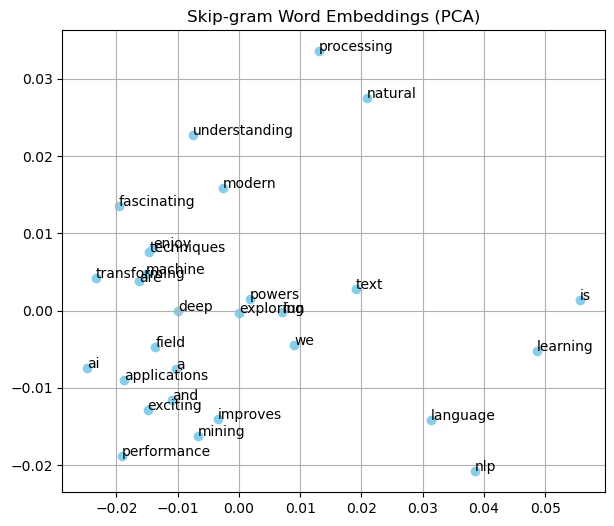

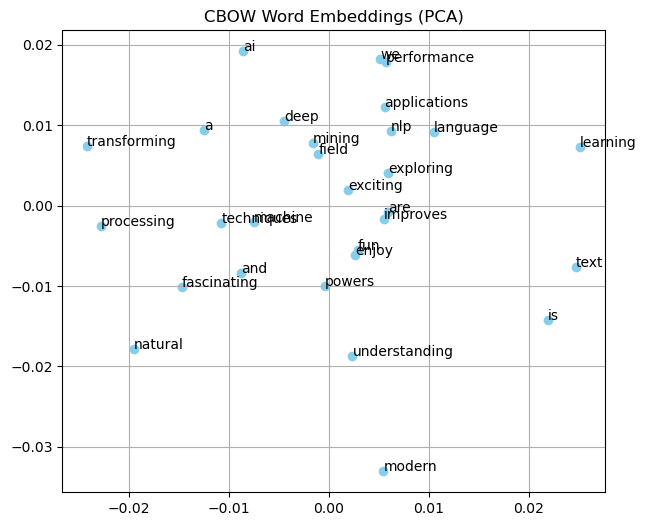

In [11]:

# -----------------------------
# 7. Visualization with PCA
# -----------------------------
def plot_embeddings(W, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(W)
    plt.figure(figsize=(7, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], color='skyblue')
    for i, word in idx2word.items():
        plt.annotate(word, (reduced[i, 0], reduced[i, 1]))
    plt.title(title)
    plt.grid(True)

plot_embeddings(W_in_sg, "Skip-gram Word Embeddings (PCA)")
plot_embeddings(W_in_cbow, "CBOW Word Embeddings (PCA)")
plt.show()
